**NOTES**

- On Kropman dataset, both columns 'SO_Omschrijving' and 'Probleemtekst' seem promising to analyze.
- One suggestion is that remove storing from the words.
- We can define a lookup table in order to save special names that we do not need so that we can remove them from the texts. Such as: Fons v Dijk
- A good approach is that before doing the traslation, we just replace the Dutch words that HORST has provided with their equivalent English words. This way we can have some of the lookup table application and also we may avoid some translation errors.
- There are also date values in the data.

In [18]:
pip install wordcloud

In [19]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm
from itertools import combinations
from wordcloud import WordCloud
from collections import Counter

In [20]:
pd.options.display.max_colwidth = None
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Collection

**Data Reading**

In [21]:
path = './Navision Serviceorder data.xlsx'

# Read the Excel file into a DataFrame
df_so = pd.read_excel(path)
df_so = df_so[df_so['Klantnaam'] == 'Kropman Onroerend Goed B.V.']
df_so.reset_index(drop=True, inplace=True)

print(df_so.info())

columns_to_select = ['SO_Omschrijving']
df_selected_so = df_so[columns_to_select].copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   KlantNr.                            28 non-null     int64  
 1   Klantnaam                           28 non-null     object 
 2   ServicecontractNr.                  28 non-null     object 
 3   Servicecontractomschrijving         28 non-null     object 
 4   Contractstatus                      28 non-null     object 
 5   ServicelocatieNr.                   28 non-null     object 
 6   LocatieOmschrijving                 28 non-null     object 
 7   SO_Nr.                              28 non-null     int64  
 8   SO_Orderdatum (Begindatum)          28 non-null     int64  
 9   Order technisch gereed (Einddatum)  27 non-null     float64
 10  SO_Status                           28 non-null     object 
 11  SO_Omschrijving                     28 non-null

**Lookup Tables**

In [22]:
lookup_table_ventilation = {
    "lbk": "Ahu",
    "luchtbehandeling": "air handling",
    "luchtbehandelen": "air handling",
    "luchbehandeling": "air handling",
    "luchtbehandeling": "air handling",
    "ventilatiesysteem": "ventilation system",
    "ventilatie": "ventilation",
    "luchtklep": "air valve",
    "stoombevochtiger": "steam humidifier",
    "stoombevochtiging": "steam humidification",
    "bevochtiger": "humidification",
    "toevoerventilator": "supply ventilator",
    "afvoerventilator": "exhaust ventilator",
    "ventilatormotor": "ventilation motor",
    "dakventilatoren": "roof ventilators",
    "Dakventilator": "roof ventilator",
    "Afzuiventilator": "exhaust ventilator",
    "wiel": "wheel",
    "afzuigvent": "exhaust vent",
    "Vsnaren": "V-belt",
    "V snaren": "V-belts",
    "filters": "filters",
    "snaarbreuk": "belt breakage",
    "condensafvoer": "condensation drain",
    "condensor": "condenser",
    "filter": "filter",
    "Luchtbeh": "air hand",
    "LBH": "AHU",
    "vorst": "frost",
    "verwarmingsbatterij": "heating battery",
    "stoomvochtiger": "steam humidifier",
    "luchtdebiet": "airflow",
    "luchtzakken": "bag filter",
    "fancoil": "fan coil",
    "splitunit": "split unit",
    "fancoil": "fan coil",
    "splitunit": "split unit",
    "fancoil": "fan-coil",
    "split-unit": "split-unit"
}

lookup_table_cooling = {
    "airco": "Airco",
    "drogekoeler": "dry cooler",
    "koelmachine": "cooling machine",
    "koeling": "cooling",
    "KM": "CM",
    "koelunit": "cooling unit",
    "koelinstallatie": "cooling installation",
    "topcooling": "top cooling",
    "gkw": "chilled water",
    "koeltoren": "cooling tower",
    "chillers": "chillers",
    "drycooler": "dry-cooler",
    "koelplafond": "cooling ceiling",
    "koelklep": "cooling valve",
    "koelwaterpomp": "cooling water pump",
    "carrier": "carrier (cooling brand)",
    "DX koeler": "DX cooler",
    "DXkoeler": "DXcooler",
    "draaikoeler": "chiller",
    "condensventilator": "condensation fan",
    "chiller": "chiller",
    "koelventilator": "cooling ventilation",
    "Condensorventilator": "condenser fan",
    "condenser": "condenser"
}

lookup_table_heating = {
    "ketel": "Boiler",
    "CV": "central heating",
    "c.v.": "central heating",
    "c.v": "central heating",
    "Kachel": "heater",
    "verwarming": "heating",
    "radiatoren": "radiators",
    "radiator": "radiator",
    "vloerverwarming": "floor heating",
    "rookgasventilator": "flue gas fan"
}

term = "lbk"
value = lookup_table_ventilation.get(term, "Unknown")
print(f"The value for '{term}' is '{value}'")

term = "koelunit"
value = lookup_table_cooling.get(term, "Unknown")
print(f"The value for '{term}' is '{value}'")

term = "verwarming"
value = lookup_table_heating.get(term, "Unknown")
print(f"The value for '{term}' is '{value}'")

The value for 'lbk' is 'Ahu'
The value for 'koelunit' is 'cooling unit'
The value for 'verwarming' is 'heating'


# Preprocessing

In [23]:
def preprocess_column(df, column='SO_Omschrijving'):
    """
    Preprocess the specified column in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """
    
    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)
    return df

def replace_special_puncs(description):
    if pd.isnull(description):
        return ''
    
    description = str(description)
    
    # Replace '-' surrounded by space characters with an empty string; such as pipe - leak.
    cleaned_description = re.sub(r'\s[-]\s', '', description)
    
    # Replace '.' symbols only when at the end of the sentence.
    cleaned_description = re.sub(r'\.\s*$', '', cleaned_description)
    
    return cleaned_description

punctuations_customized = '!"#$%&\'()*+,-/:;<=>?@[\]^_`{|}~'

def remove_punctuation(text):
    """
    Remove punctuation from the input text.

    Parameters:
    - text (str): The input text from which punctuation will be removed.

    Returns:
    - str: The input text with punctuation removed.
    """
    # Create a translation table to replace punctuation with spaces
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

    cleaned_text = text.translate(translator)

    return cleaned_text

def remove_numberical_values(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    if isinstance(text, str):
        # Remove standalone numbers with optional floating points; such as 154, 99.31.
        text = re.sub(r'\b\d+(\.\d+)?\b', '', text)
        
        # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
        text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)
        
        # Remove numerical quantifiers; such as 1x OH.
        text = re.sub(r'\b\d+[xX]\b', '', text)
        
        return text
    else:
        return text

fault_service_orders = preprocess_column(df_selected_so, column='SO_Omschrijving')
print(f'Initial Dataset:\n\n{fault_service_orders.head(20)}')

fault_service_orders['SO_Omschrijving'] = fault_service_orders['SO_Omschrijving'].apply(remove_punctuation)
print(f'\n\nAfter Removing Punctuations:\n\n{fault_service_orders.head(20)}')

fault_service_orders['SO_Omschrijving'] = fault_service_orders['SO_Omschrijving'].apply(remove_numberical_values)
print(f'\n\nAfter Removing Numbers and Models:\n\n{fault_service_orders.head(20)}')

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
fault_service_orders['SO_Omschrijving'] = fault_service_orders['SO_Omschrijving'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
print(f'\n\nAfter Removing Dutch Stop Words:\n\n{fault_service_orders.head(20)}')

Initial Dataset:

                                SO_Omschrijving
0                       Storing noodverlichting
1                        Warmtewiel storing LBK
2               Koeling serverruimte werkt niet
3                        Warmtewiel storing LBK
4                       Storing noodverlichting
5         Verlichting nazien bij copierapparaat
6                     Verstopping linker toilet
7                             Herstellen poort.
8                        Lekkage koelsectie LBK
9            Verlichting defect in toilet 1 ver
10                       Defecte verlichting BG
11                       Defecte verlichting BG
12         (MP) storing GBS maximaal hygrostaat
13    (RA)Meldingen via GBS maximaal hygrostaat
14  (RA) Meldingen via GBS  maximaal hygrostaat
15   (RA)Meldingen via GBS  maximaal hygrostaat
16                        Lift staat in storing
17                     (IV) Kone Lift is defect
18        Op de 1 ver kraan defect. De uitloop 
19               Repar

**Document-term Matrix Creation**

**NOTES**
- If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
- Lowercasing is done by default.

In [24]:
# Assuming df_selected is your DataFrame with a 'Description' column
corpus_so = fault_service_orders['SO_Omschrijving'].tolist()

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the corpus to create the document-term matrix
dtm = vectorizer.fit_transform(corpus_so)

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

# Convert the document-term matrix to a DataFrame
dtm_df_so = pd.DataFrame(dtm.toarray(), columns=terms)

dtm_df_so

,bg,breda,copierapparaat,data,defect,defecte,gbs,herstellen,hygrostaat,inbraakinstallatie,...,toilet,uitloop,ver,verbinding,verd,verlichting,verstopping,via,warmtewiel,werkt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


**Average Number of Terms**

In [25]:
# Calculate the average number of terms used in service orders.
average_terms = dtm_df_so.sum(axis=1).mean()
print(f'Average Number of Terms in service orders: {average_terms:.2f}')

Average Number of Terms in service orders: 3.46


**Sparse Matrix Analysis**

In [26]:
total_entries = dtm_df_so.size
non_zero_entries = np.count_nonzero(dtm_df_so)
sparsity = 1.0 - (non_zero_entries / total_entries)
print(f'Sparsity of Service Order Document-Term Matrix: {sparsity:.2%}')

Sparsity of Service Order Document-Term Matrix: 93.58%


**Term Frequency Analysis**

In [27]:
term_frequencies_so = dtm_df_so.sum()

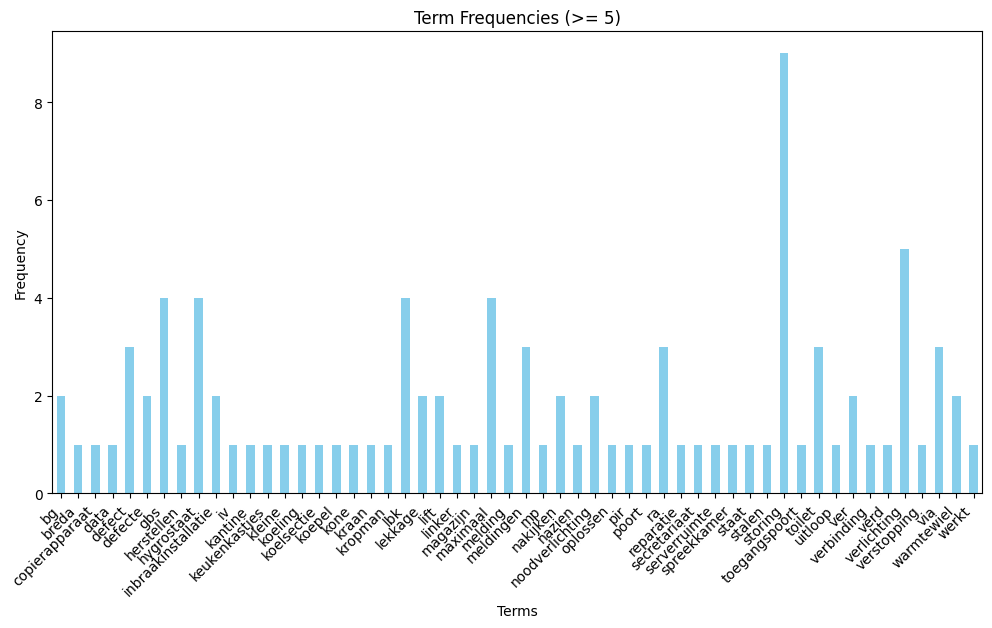

In [30]:
# Assuming term_frequencies is a pandas Series with terms as index and frequencies as values
filtered_terms = term_frequencies_so

filtered_terms.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Term Frequencies (>= 5)')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# Assuming term_frequencies is a pandas Series with terms as index and frequencies as values
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_frequencies_so)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Term Frequencies**

In [ ]:
pre_processed_corpus = [word.lower() for sentence in corpus_so for word in sentence.split()]
term_frequencies_so = Counter(pre_processed_corpus)
print(f'Number of terms: {len(term_frequencies_so)}')

In [ ]:
top_terms = term_frequencies_so.most_common(50)

# Extract terms and frequencies for plotting.
terms, frequencies = zip(*top_terms)

# Create a line chart
plt.figure(figsize=(12, 6))
plt.plot(terms, frequencies, marker='o', linestyle='-', color='b')

# Customize the plot
plt.title('Top 50 Frequent Words')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability.
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

**TF-IDF Analysis**

In [ ]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the corpus to create the TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(corpus_so)

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

# Display the top terms based on their normalized TF-IDF scores
top_terms = tfidf_df.mean(axis=0).sort_values(ascending=False).head(51)
print(top_terms)

**Clean corpus**

In [ ]:
corpus_so = [phrase for phrase in corpus_so if pd.notna(phrase) and phrase != '']

**Calculate Support**

In [ ]:
# Get a list of unique terms in the dataset
unique_terms = set(' '.join(corpus_so).split())

# Generate all possible pairs of terms
term_pairs = list(combinations(unique_terms, 3))

print(f'Number of Combinations: {len(term_pairs)}\n')
print(f'Number of Service Orders: {len(corpus_so)}\n')

# Calculate support for each term pair
support_values = []

for term_pair in term_pairs:
    target_terms = list(term_pair)
    
    # Count the number of transactions containing the target terms
    phrases_with_terms = []
    for phrase in corpus_so:
        # Use regular expression to match whole words
        if all(re.search(rf'\b{re.escape(term)}\b', phrase) for term in target_terms):
            phrases_with_terms.append(phrase)
    
    # Calculate support as the ratio of transactions with terms to total transactions
    support = len(phrases_with_terms) / len(corpus_so)
    
    # Store the support value and term pair
    support_values.append((support, target_terms))

# Sort the support values in descending order
support_values.sort(reverse=True)

# Print the results
for i, (support, terms) in enumerate(support_values):
    print(f"Support for terms {terms}: {support:.2%}")
    if i == 50:
        break

In [ ]:
# # Define the pairs for which you want to find occurrences
# pairs_to_find = [['stoomomvormer', 'Storing']]

# # Iterate through the corpus and print the phrases containing each pair
# for pair in pairs_to_find:
#     term1, term2 = pair
#     print(f"Occurrences for terms {pair}:")
#     for phrase in corpus:
#         # Use regular expression to match whole words
#         if re.search(rf'\b{re.escape(term1)}\b', phrase) and re.search(rf'\b{re.escape(term2)}\b', phrase):
#             print(f"   - {phrase}")


**Calculate Confidence**

In [ ]:
# Calculate confidence for each term pair
confidence_values = []

for support, terms in support_values:
    antecedent = terms[0]
    consequent = terms[1]
    
    # Count the number of transactions containing both antecedent and consequent
    phrases_with_both = [phrase for phrase in corpus if antecedent in phrase and consequent in phrase]
    
    # Calculate confidence as the ratio of transactions with both terms to transactions with antecedent
    confidence = len(phrases_with_both) / len([phrase for phrase in corpus if antecedent in phrase])
    
    # Store the confidence value and term pair
    confidence_values.append((confidence, terms))

# Sort the confidence values in descending order
confidence_values.sort(reverse=True)

# Print the results
for i, (confidence, terms) in enumerate(confidence_values):
    print(f"Confidence for terms {terms}: {confidence:.2%}")
    if i == 500:
        break


**Calculate Lift**

In [ ]:
# Calculate lift for each term pair
lift_values = []

for support, terms in support_values:
    antecedent = terms[0]
    consequent = terms[1]
    
    # Count the number of transactions containing both antecedent and consequent
    phrases_with_both = [phrase for phrase in corpus if antecedent in phrase and consequent in phrase]
    
    # Calculate lift using the formula
    lift = len(phrases_with_both) / (len([phrase for phrase in corpus if antecedent in phrase]) * len([phrase for phrase in corpus if consequent in phrase]))
    
    # Store the lift value and term pair
    lift_values.append((lift, terms))

# Sort the lift values in descending order
lift_values.sort(reverse=True)

# Print the results
for i, (lift, terms) in enumerate(lift_values):
    print(f"Lift for terms {terms}: {lift:.4f}")
    if i == 200:
        break
